In [202]:
import numpy as nu
import scanpy as sc
import pandas as pd
from scipy.sparse import csr_matrix

from matplotlib import pyplot as plt
from matplotlib import rcParams
%matplotlib inline

import leidenalg
import numpy.core.multiarray

In [2]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=200, facecolor='white')

/opt/conda/envs/spatialdata/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.10.4 anndata==0.11.1 umap==0.5.3 numpy==1.26.4 scipy==1.10.1 pandas==2.0.2 scikit-learn==1.2.2 statsmodels==0.14.0 igraph==0.10.4 pynndescent==0.5.10


In [36]:
adata_main = sc.read("/home/jovyan/ifbdata/spatial_cell_id/Kush/data/Clarins_concatenated_adata.h5ad")

/opt/conda/envs/spatialdata/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [205]:
adata = adata_main.copy()

/opt/conda/envs/spatialdata/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [206]:
adata

AnnData object with n_obs × n_vars = 783686 × 20116
    obs: 'Dataset', 'Age', 'Sex', 'Skin area', 'Ethnicity', 'Publication'

In [207]:
adata.var_names_make_unique() #makes the gene names unique by appending a number string to each duplicate index element

In [208]:
adata.obs_names_make_unique() #makes the cell names unique by appending a number string to each duplicate index element
# alternative to reindexing part 

In [209]:
adata

AnnData object with n_obs × n_vars = 783686 × 20116
    obs: 'Dataset', 'Age', 'Sex', 'Skin area', 'Ethnicity', 'Publication'

In [210]:
print(adata.obs.index.is_unique)

True


In [211]:
# Ribosomal genes and micochondrial genes are detected, and their percentage in each cell is generated and saved

adata.var['ribo'] = adata.var_names.str.startswith(("RpS","RpL"))
adata.var['mt'] = adata.var_names.str.startswith(("Mt", "MT")) #had to include "MT" for our case

sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo', 'mt'], percent_top=None, log1p=False, inplace=True)

normalizing counts per cell


/opt/conda/envs/spatialdata/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


    finished (0:00:06)


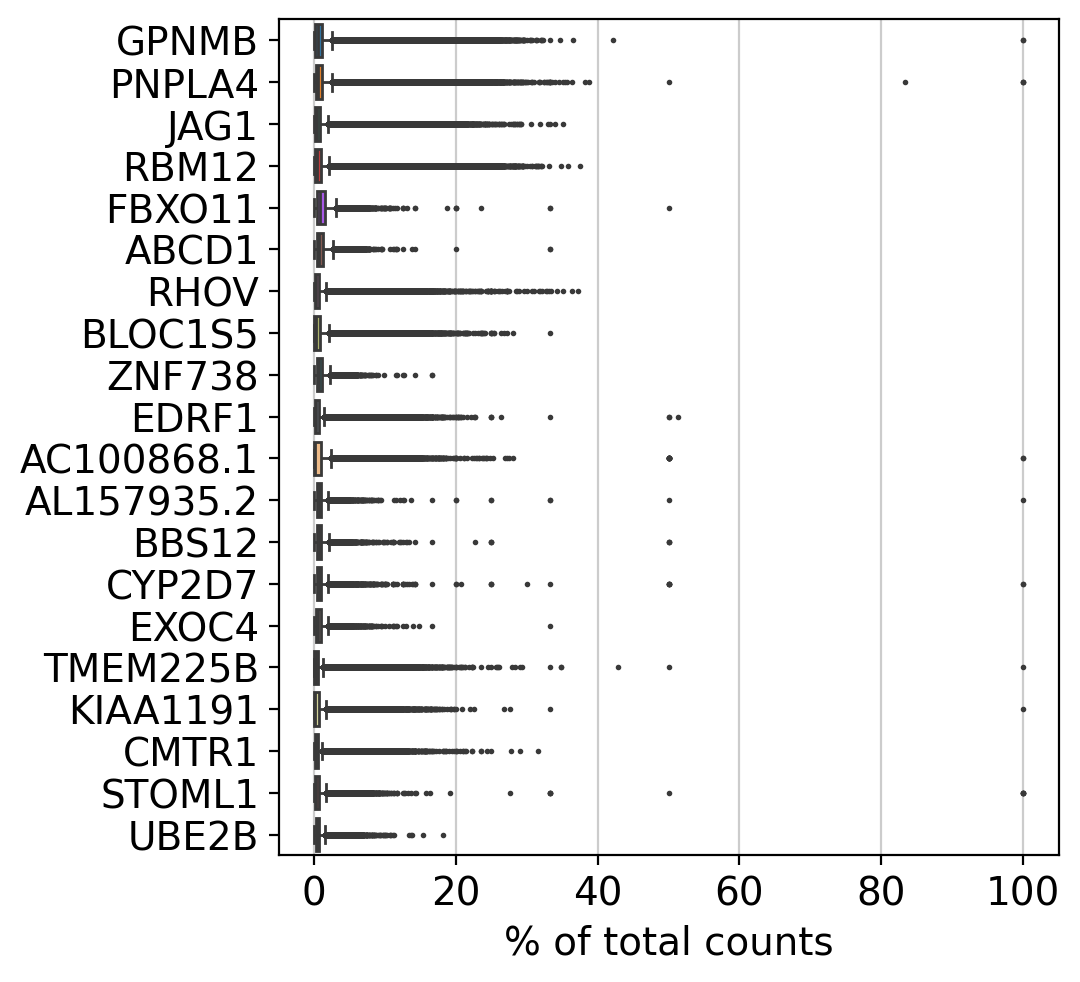

In [212]:
sc.settings.set_figure_params(dpi=100, facecolor='white')
sc.pl.highest_expr_genes(adata, n_top=20)

In [213]:
print(adata.obs['Publication'].value_counts())

Publication
multiscale_spacial_mapping               277891
eyelids_full_skin                        233078
multiscale_spacial_mapping_2             187794
sun_protected_human_skin_inguinoiliac     31302
atopic_dermatitis_healthy                 27096
Dermal_sheath_outer_forearm               24589
photoaging_extensor_side                   1936
Name: count, dtype: int64


In [215]:
print(adata.obs.index[adata.obs.index.duplicated()]) #524412 duplicate cells (66.9%) 
# no duplicates after the "adata.obs_names_make_unique()"

Index([], dtype='object')


In [168]:
# no need for this step now 

# adata.obs['cell_names'] = adata.obs.index #making the cells column to a new column instead of index
# adata.obs.reset_index(drop=True, inplace=True) #and re indexing to unique numbering from 0 

# to not loose the info about cells and still be able to use index for grouping

In [216]:
adata.obs

Dataset    Age     Sex      Skin area  \
GAACACTTCATTGCGA    WS_SKN_KCL9369629_S1     80    Male       forehead   
TCTCACGTCCGCACTT    WS_SKN_KCL9369629_S1     80    Male       forehead   
CTCCAACTCTCCTACG    WS_SKN_KCL9369629_S1     80    Male       forehead   
AGATGAAAGACTCGAG    WS_SKN_KCL9369629_S1     80    Male       forehead   
GCTACCTAGCAATAAC    WS_SKN_KCL9369629_S1     80    Male       forehead   
...                                  ...    ...     ...            ...   
ACTCTAATCGGTTAAC             SRR15440585  74.25  Female  outer forearm   
AGACGTTTCCGTACAA             SRR15440585  74.25  Female  outer forearm   
CCGGGATCAGCAGTTT             SRR15440585  74.25  Female  outer forearm   
CGGTTAACAAGTCTAC             SRR15440585  74.25  Female  outer forearm   
GTAACGTTCTTTACAC-1           SRR15440585  74.25  Female  outer forearm   

                    Ethnicity                  Publication  n_genes_by_counts  \
GAACACTTCATTGCGA    not known   multiscale_spacial_mapping               2492   
TCTCACGTCCGCACTT    not known   multiscale_spacial_mapping               3143   
CTCCAACTCTCCTACG    not known   multiscale_spacial_mapping               2818   
AGATGAAAGACTCGAG    not known   multiscale_spacial_mapping               2762   
GCTACCTAGCAATAAC    not known   multiscale_spacial_mapping               3401   
...                       ...                          ...                ...   
ACTCTAATCGGTTAAC    Caucasian  Dermal_sheath_outer_forearm                283   
AGACGTTTCCGTACAA    Caucasian  Dermal_sheath_outer_forearm                 44   
CCGGGATCAGCAGTTT    Caucasian  Dermal_sheath_outer_forearm                 50   
CGGTTAACAAGTCTAC    Caucasian  Dermal_sheath_outer_forearm                 49   
GTAACGTTCTTTACAC-1  Caucasian  Dermal_sheath_outer_forearm                 59   

                    total_counts  total_counts_ribo  pct_counts_ribo  \
GAACACTTCATTGCGA     8085.142578                0.0              0.0   
TCTCACGTCCGCACTT    10122.234375                0.0              0.0   
CTCCAACTCTCCTACG     7325.214844                0.0              0.0   
AGATGAAAGACTCGAG     8198.296875                0.0              0.0   
GCTACCTAGCAATAAC    13108.109375                0.0              0.0   
...                          ...                ...              ...   
ACTCTAATCGGTTAAC      420.452362                0.0              0.0   
AGACGTTTCCGTACAA       51.250000                0.0              0.0   
CCGGGATCAGCAGTTT       53.833332                0.0              0.0   
CGGTTAACAAGTCTAC       58.000000                0.0              0.0   
GTAACGTTCTTTACAC-1     55.666664                0.0              0.0   

                    total_counts_mt  pct_counts_mt  
GAACACTTCATTGCGA          60.833336       0.752409  
TCTCACGTCCGCACTT          46.333332       0.457738  
CTCCAACTCTCCTACG          38.833336       0.530132  
AGATGAAAGACTCGAG          29.000000       0.353732  
GCTACCTAGCAATAAC          68.000000       0.518763  
...                             ...            ...  
ACTCTAATCGGTTAAC           1.000000       0.237839  
AGACGTTTCCGTACAA           0.000000       0.000000  
CCGGGATCAGCAGTTT           0.000000       0.000000  
CGGTTAACAAGTCTAC           0.000000       0.000000  
GTAACGTTCTTTACAC-1         0.000000       0.000000  

[783686 rows x 12 columns]

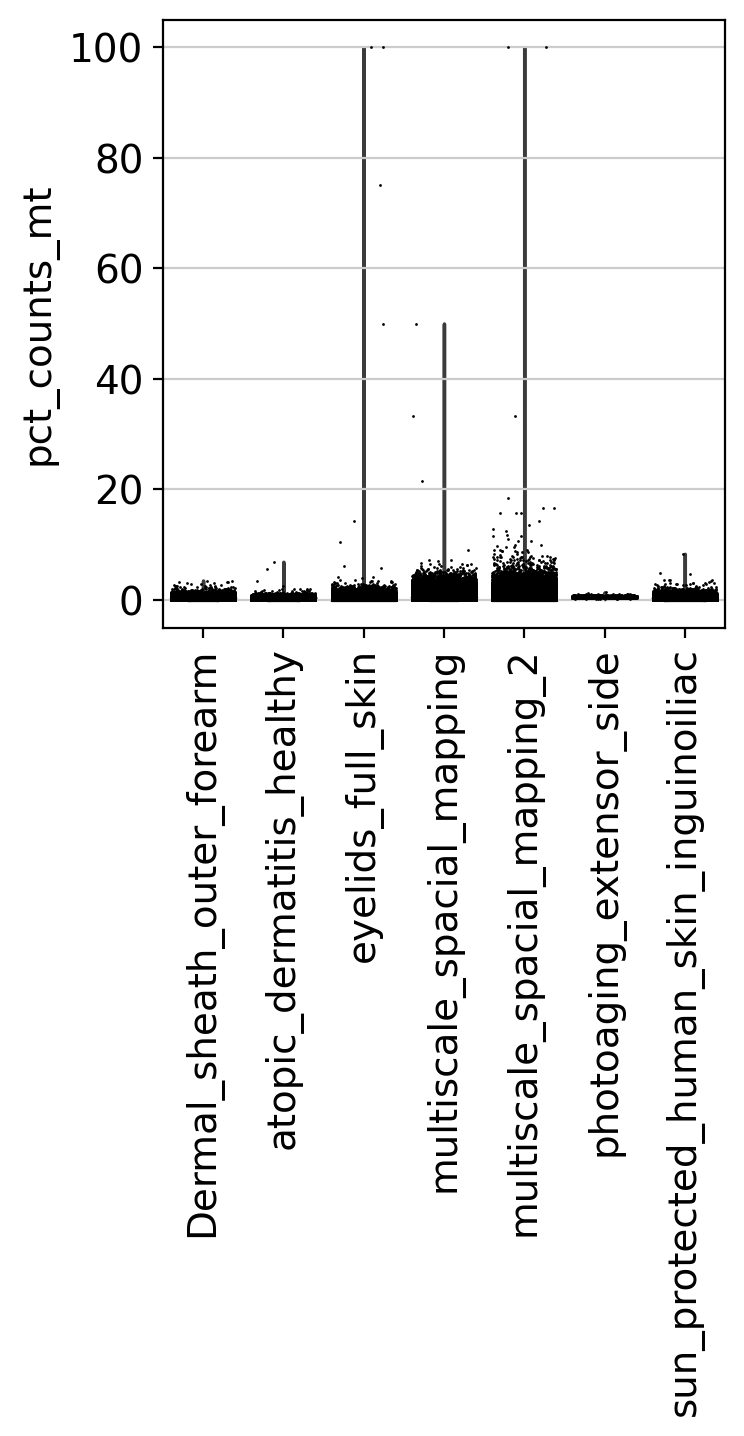

In [218]:
sc.settings.set_figure_params(dpi = 100, facecolor='white')
sc.pl.violin(adata, ['pct_counts_mt'], jitter=0.4, groupby = 'Publication', rotation= 90)
# percentage of mitochondrial gene expression 

In [219]:
adata.obs['pct_counts_mt'].max() #just to check if the percentange column was divided by 100 or not, it isn't

100.0

In [220]:
# filter the cells expressing more than 20% of mitochondrial genes (852 removed)
adata = adata[adata.obs['pct_counts_mt'] < 20, :]

print("Remaining cells %d" %adata.n_obs)

Remaining cells 782834


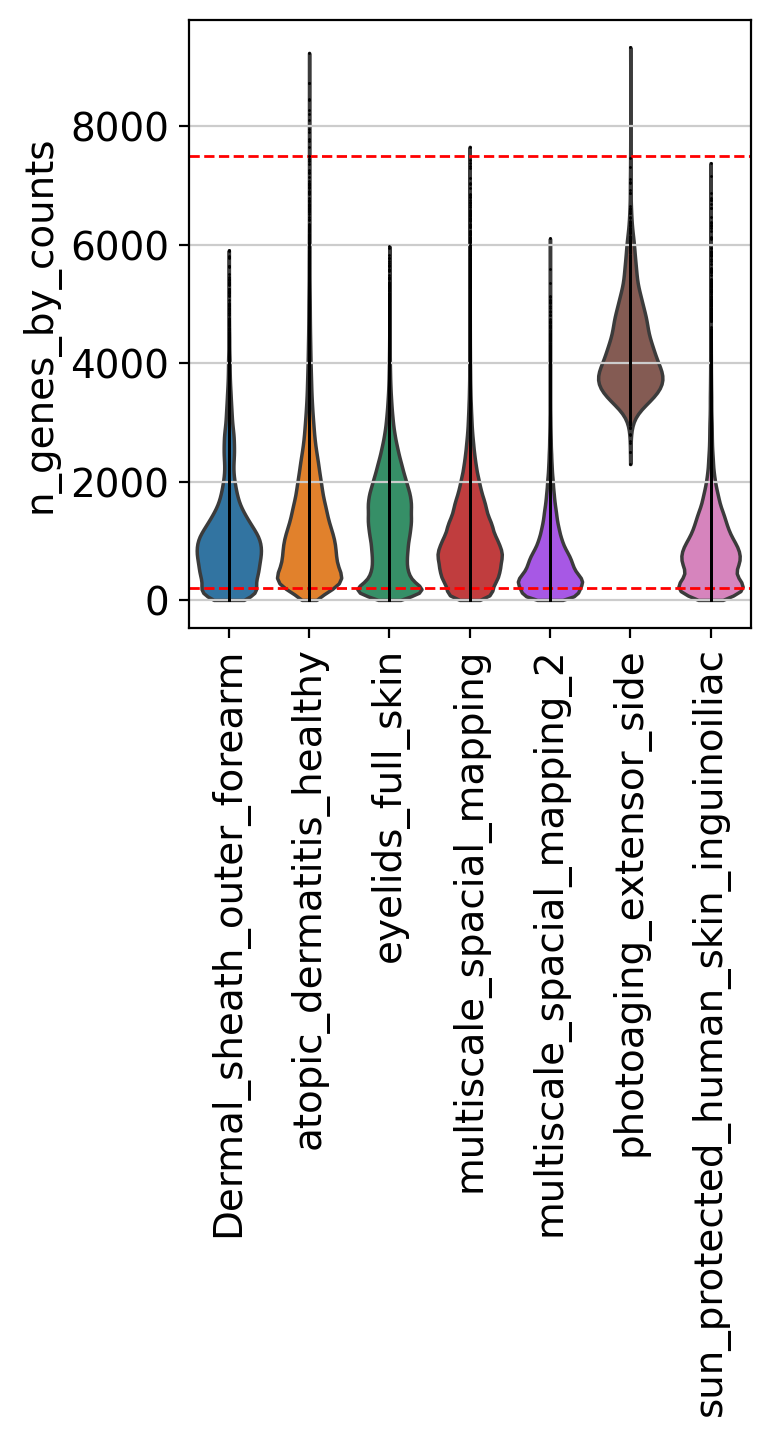

In [221]:
# visualizing the number of genes and the total counts for each publication
sc.settings.set_figure_params(dpi = 100, facecolor='white')
sc.pl.violin(adata, ['n_genes_by_counts'], jitter=0, groupby = 'Publication', rotation= 90, show=False) 
plt.axhline(y=200, color='red', linestyle='--', linewidth=1)
plt.axhline(y=7500, color='red', linestyle='--', linewidth=1)

plt.show()
# red lines show the filtering criteria set
# n_genes_by_counts = how many genes are being actively transcribed in the cell (number of genes that have non-zero expression)

#  show=False will not plot the voilin and plt.axhline will add the horizontal lines and then plt.show will print with lines

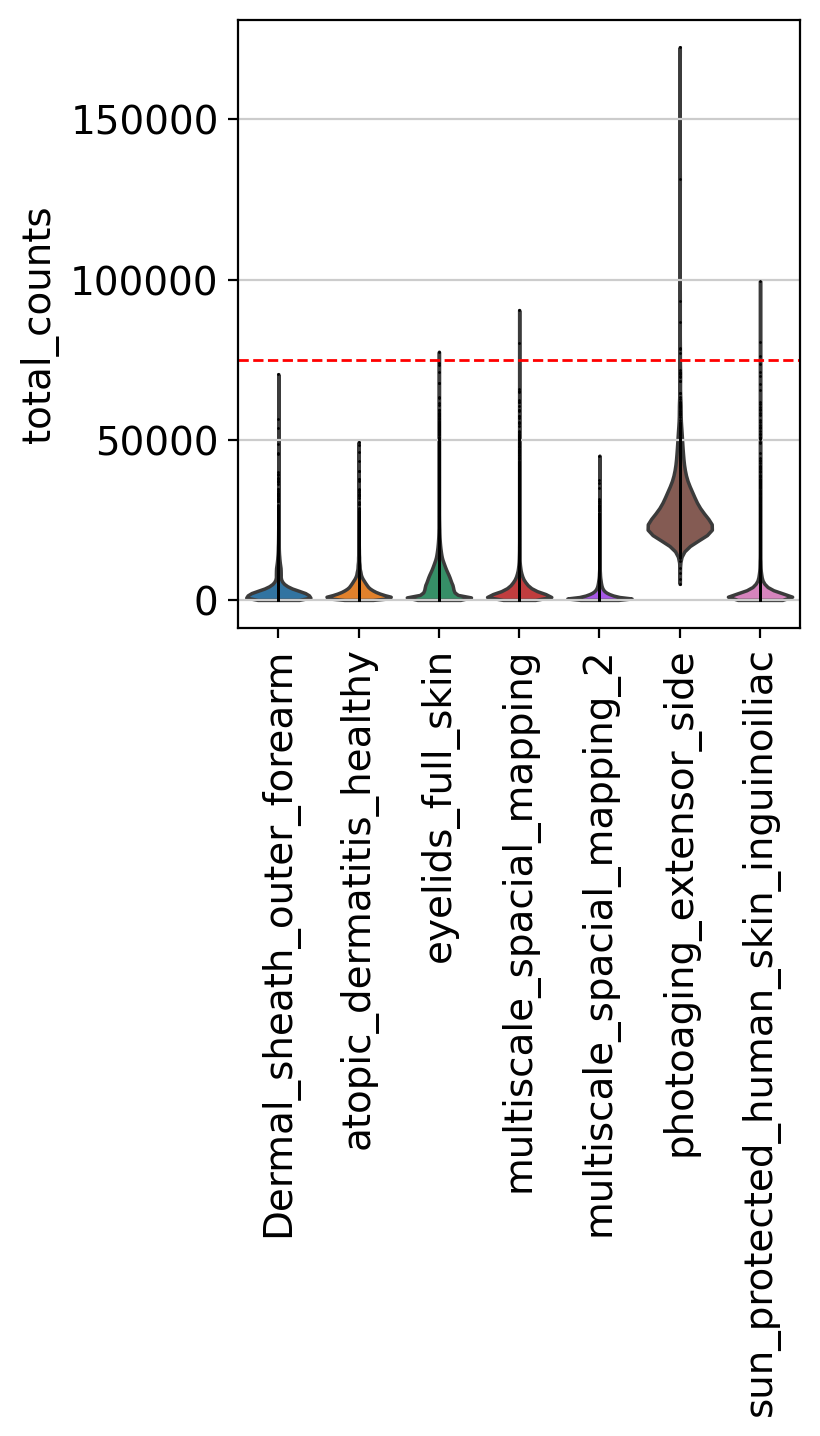

In [222]:
sc.settings.set_figure_params(dpi = 100, facecolor='white')
sc.pl.violin(adata, ['total_counts'], jitter=0, groupby = 'Publication', rotation= 90, show=False)
plt.axhline(y=75000, color='red', linestyle='--', linewidth=1)

plt.show()

# red lines show the filtering criteria set
# total_counts = total number of RNA counts (or reads) for a particular cell (sum of all gene expression counts for that cell)

In [223]:
adata.obs

Dataset    Age     Sex      Skin area  \
GAACACTTCATTGCGA    WS_SKN_KCL9369629_S1     80    Male       forehead   
TCTCACGTCCGCACTT    WS_SKN_KCL9369629_S1     80    Male       forehead   
CTCCAACTCTCCTACG    WS_SKN_KCL9369629_S1     80    Male       forehead   
AGATGAAAGACTCGAG    WS_SKN_KCL9369629_S1     80    Male       forehead   
GCTACCTAGCAATAAC    WS_SKN_KCL9369629_S1     80    Male       forehead   
...                                  ...    ...     ...            ...   
ACTCTAATCGGTTAAC             SRR15440585  74.25  Female  outer forearm   
AGACGTTTCCGTACAA             SRR15440585  74.25  Female  outer forearm   
CCGGGATCAGCAGTTT             SRR15440585  74.25  Female  outer forearm   
CGGTTAACAAGTCTAC             SRR15440585  74.25  Female  outer forearm   
GTAACGTTCTTTACAC-1           SRR15440585  74.25  Female  outer forearm   

                    Ethnicity                  Publication  n_genes_by_counts  \
GAACACTTCATTGCGA    not known   multiscale_spacial_mapping               2492   
TCTCACGTCCGCACTT    not known   multiscale_spacial_mapping               3143   
CTCCAACTCTCCTACG    not known   multiscale_spacial_mapping               2818   
AGATGAAAGACTCGAG    not known   multiscale_spacial_mapping               2762   
GCTACCTAGCAATAAC    not known   multiscale_spacial_mapping               3401   
...                       ...                          ...                ...   
ACTCTAATCGGTTAAC    Caucasian  Dermal_sheath_outer_forearm                283   
AGACGTTTCCGTACAA    Caucasian  Dermal_sheath_outer_forearm                 44   
CCGGGATCAGCAGTTT    Caucasian  Dermal_sheath_outer_forearm                 50   
CGGTTAACAAGTCTAC    Caucasian  Dermal_sheath_outer_forearm                 49   
GTAACGTTCTTTACAC-1  Caucasian  Dermal_sheath_outer_forearm                 59   

                    total_counts  total_counts_ribo  pct_counts_ribo  \
GAACACTTCATTGCGA     8085.142578                0.0              0.0   
TCTCACGTCCGCACTT    10122.234375                0.0              0.0   
CTCCAACTCTCCTACG     7325.214844                0.0              0.0   
AGATGAAAGACTCGAG     8198.296875                0.0              0.0   
GCTACCTAGCAATAAC    13108.109375                0.0              0.0   
...                          ...                ...              ...   
ACTCTAATCGGTTAAC      420.452362                0.0              0.0   
AGACGTTTCCGTACAA       51.250000                0.0              0.0   
CCGGGATCAGCAGTTT       53.833332                0.0              0.0   
CGGTTAACAAGTCTAC       58.000000                0.0              0.0   
GTAACGTTCTTTACAC-1     55.666664                0.0              0.0   

                    total_counts_mt  pct_counts_mt  
GAACACTTCATTGCGA          60.833336       0.752409  
TCTCACGTCCGCACTT          46.333332       0.457738  
CTCCAACTCTCCTACG          38.833336       0.530132  
AGATGAAAGACTCGAG          29.000000       0.353732  
GCTACCTAGCAATAAC          68.000000       0.518763  
...                             ...            ...  
ACTCTAATCGGTTAAC           1.000000       0.237839  
AGACGTTTCCGTACAA           0.000000       0.000000  
CCGGGATCAGCAGTTT           0.000000       0.000000  
CGGTTAACAAGTCTAC           0.000000       0.000000  
GTAACGTTCTTTACAC-1         0.000000       0.000000  

[782834 rows x 12 columns]

In [225]:
# no need for this now
# adata.obs.reset_index(drop=True, inplace=True)

In [226]:
adata = adata[adata.obs['n_genes_by_counts'] > 200, :]
print("Remaining cells %d" %adata.n_obs)

Remaining cells 693323


In [227]:
adata = adata[adata.obs['n_genes_by_counts'] < 7500, :]
print("Remaining cells %d" %adata.n_obs)

Remaining cells 693306


In [228]:
adata = adata[adata.obs['total_counts'] < 75000, :]
print("Remaining cells %d" %adata.n_obs)

Remaining cells 693294


In [229]:
adata.obs

Dataset    Age     Sex      Skin area  \
GAACACTTCATTGCGA    WS_SKN_KCL9369629_S1     80    Male       forehead   
TCTCACGTCCGCACTT    WS_SKN_KCL9369629_S1     80    Male       forehead   
CTCCAACTCTCCTACG    WS_SKN_KCL9369629_S1     80    Male       forehead   
AGATGAAAGACTCGAG    WS_SKN_KCL9369629_S1     80    Male       forehead   
GCTACCTAGCAATAAC    WS_SKN_KCL9369629_S1     80    Male       forehead   
...                                  ...    ...     ...            ...   
AACCAGGAGATAGGAG             SRR15440585  74.25  Female  outer forearm   
AAGGCATAGGGCATGT             SRR15440585  74.25  Female  outer forearm   
AGGGAAGCAGCATACT             SRR15440585  74.25  Female  outer forearm   
CAGCCGAGTTCCCTTG-1           SRR15440585  74.25  Female  outer forearm   
ACTCTAATCGGTTAAC             SRR15440585  74.25  Female  outer forearm   

                    Ethnicity                  Publication  n_genes_by_counts  \
GAACACTTCATTGCGA    not known   multiscale_spacial_mapping               2492   
TCTCACGTCCGCACTT    not known   multiscale_spacial_mapping               3143   
CTCCAACTCTCCTACG    not known   multiscale_spacial_mapping               2818   
AGATGAAAGACTCGAG    not known   multiscale_spacial_mapping               2762   
GCTACCTAGCAATAAC    not known   multiscale_spacial_mapping               3401   
...                       ...                          ...                ...   
AACCAGGAGATAGGAG    Caucasian  Dermal_sheath_outer_forearm                301   
AAGGCATAGGGCATGT    Caucasian  Dermal_sheath_outer_forearm                310   
AGGGAAGCAGCATACT    Caucasian  Dermal_sheath_outer_forearm                282   
CAGCCGAGTTCCCTTG-1  Caucasian  Dermal_sheath_outer_forearm                246   
ACTCTAATCGGTTAAC    Caucasian  Dermal_sheath_outer_forearm                283   

                    total_counts  total_counts_ribo  pct_counts_ribo  \
GAACACTTCATTGCGA     8085.142578                0.0              0.0   
TCTCACGTCCGCACTT    10122.234375                0.0              0.0   
CTCCAACTCTCCTACG     7325.214844                0.0              0.0   
AGATGAAAGACTCGAG     8198.296875                0.0              0.0   
GCTACCTAGCAATAAC    13108.109375                0.0              0.0   
...                          ...                ...              ...   
AACCAGGAGATAGGAG      390.850006                0.0              0.0   
AAGGCATAGGGCATGT      410.831299                0.0              0.0   
AGGGAAGCAGCATACT      382.616669                0.0              0.0   
CAGCCGAGTTCCCTTG-1    367.124817                0.0              0.0   
ACTCTAATCGGTTAAC      420.452362                0.0              0.0   

                    total_counts_mt  pct_counts_mt  
GAACACTTCATTGCGA          60.833336       0.752409  
TCTCACGTCCGCACTT          46.333332       0.457738  
CTCCAACTCTCCTACG          38.833336       0.530132  
AGATGAAAGACTCGAG          29.000000       0.353732  
GCTACCTAGCAATAAC          68.000000       0.518763  
...                             ...            ...  
AACCAGGAGATAGGAG           1.000000       0.255853  
AAGGCATAGGGCATGT           2.333333       0.567954  
AGGGAAGCAGCATACT           1.000000       0.261358  
CAGCCGAGTTCCCTTG-1         1.500000       0.408580  
ACTCTAATCGGTTAAC           1.000000       0.237839  

[693294 rows x 12 columns]

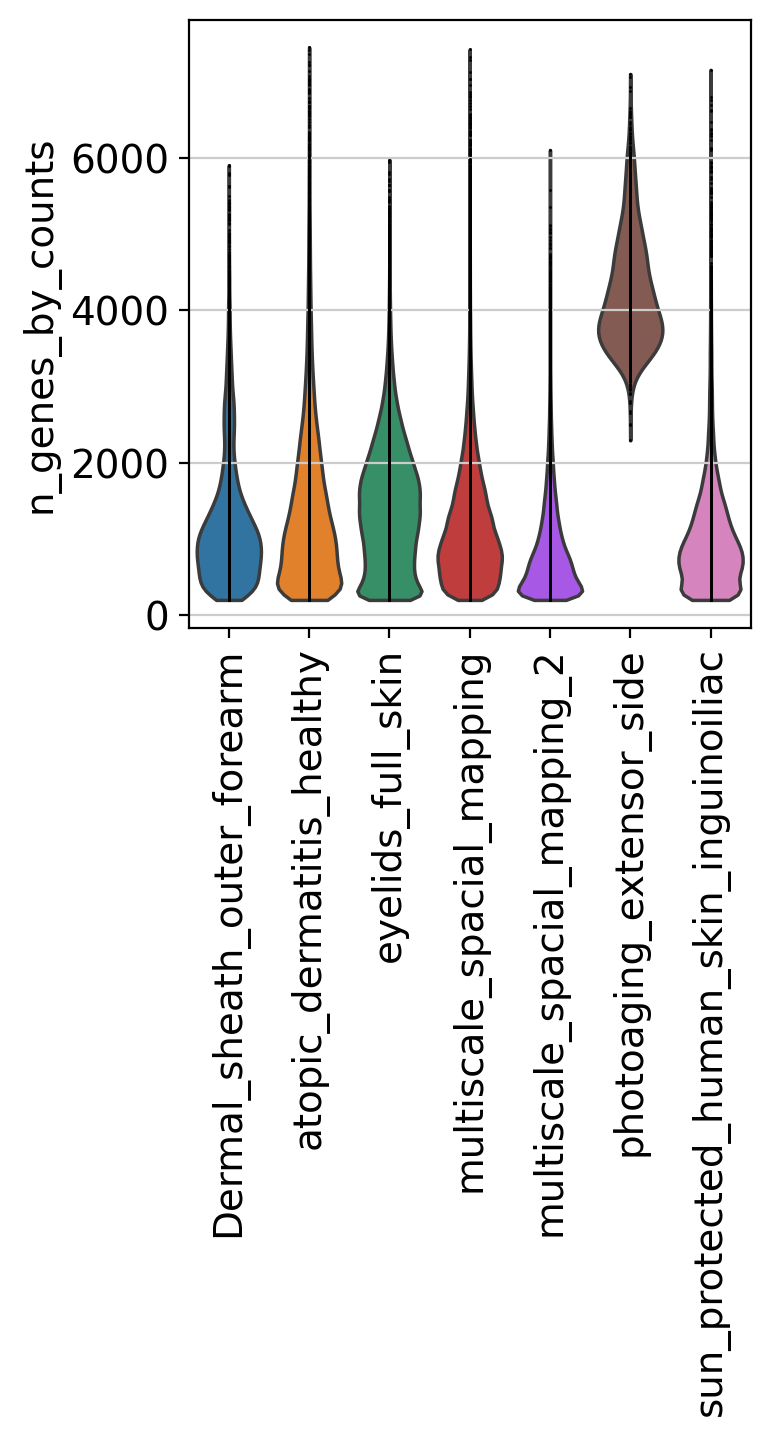

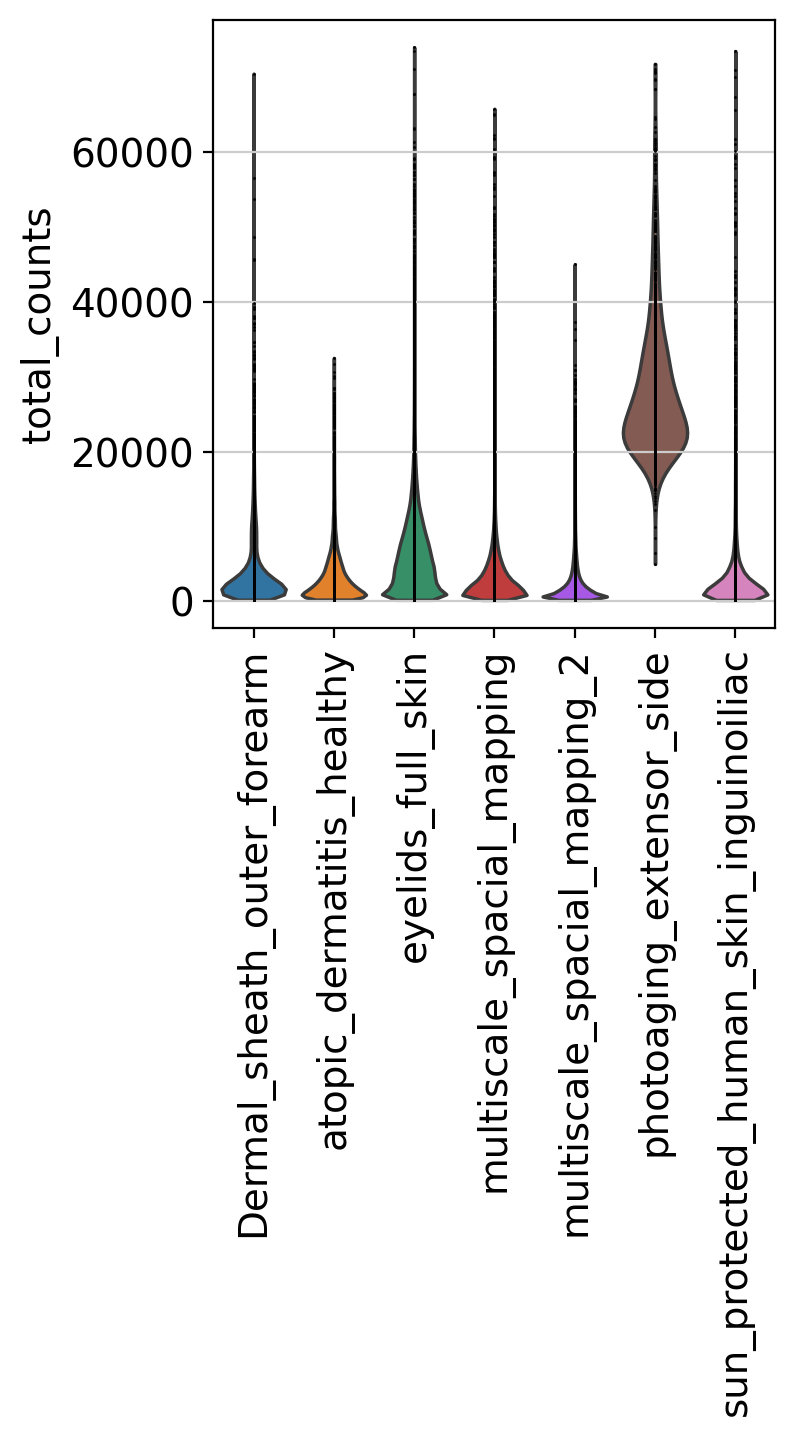

In [230]:
# now after the filteration
# setting the jitter to 0 to visualize violins due to high number of genes
sc.settings.set_figure_params(dpi = 100, facecolor='white')
sc.pl.violin(adata, ['n_genes_by_counts'], jitter=0, groupby = 'Publication', rotation= 90)
sc.pl.violin(adata, ['total_counts'], jitter=0, groupby = 'Publication', rotation= 90)

In [231]:
# setting filter of minimum genes expressed = 200
sc.pp.filter_cells(adata, min_genes=200)
print("Remaining cells %d" %adata.n_obs) # another way of printing

/opt/conda/envs/spatialdata/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:168: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


Remaining cells 693294


In [232]:
# setting filter of gene minimum expressed in 3 cells to be included
sc.pp.filter_genes(adata, min_cells=3)
print(f"Remaining genes: {adata.n_vars}") 

filtered out 894 genes that are detected in less than 3 cells
Remaining genes: 19222


In [233]:
adata2 = adata.copy() #this is the filtered adata

In [234]:
adata2

AnnData object with n_obs × n_vars = 693294 × 19222
    obs: 'Dataset', 'Age', 'Sex', 'Skin area', 'Ethnicity', 'Publication', 'n_genes_by_counts', 'total_counts', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'ribo', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'Publication_colors'

In [235]:
# exporting the fitered adata for easy further access
adata2.write("/home/jovyan/ifbdata/spatial_cell_id/Kush/Scanpy_analysis/adata_filtered.h5ad")

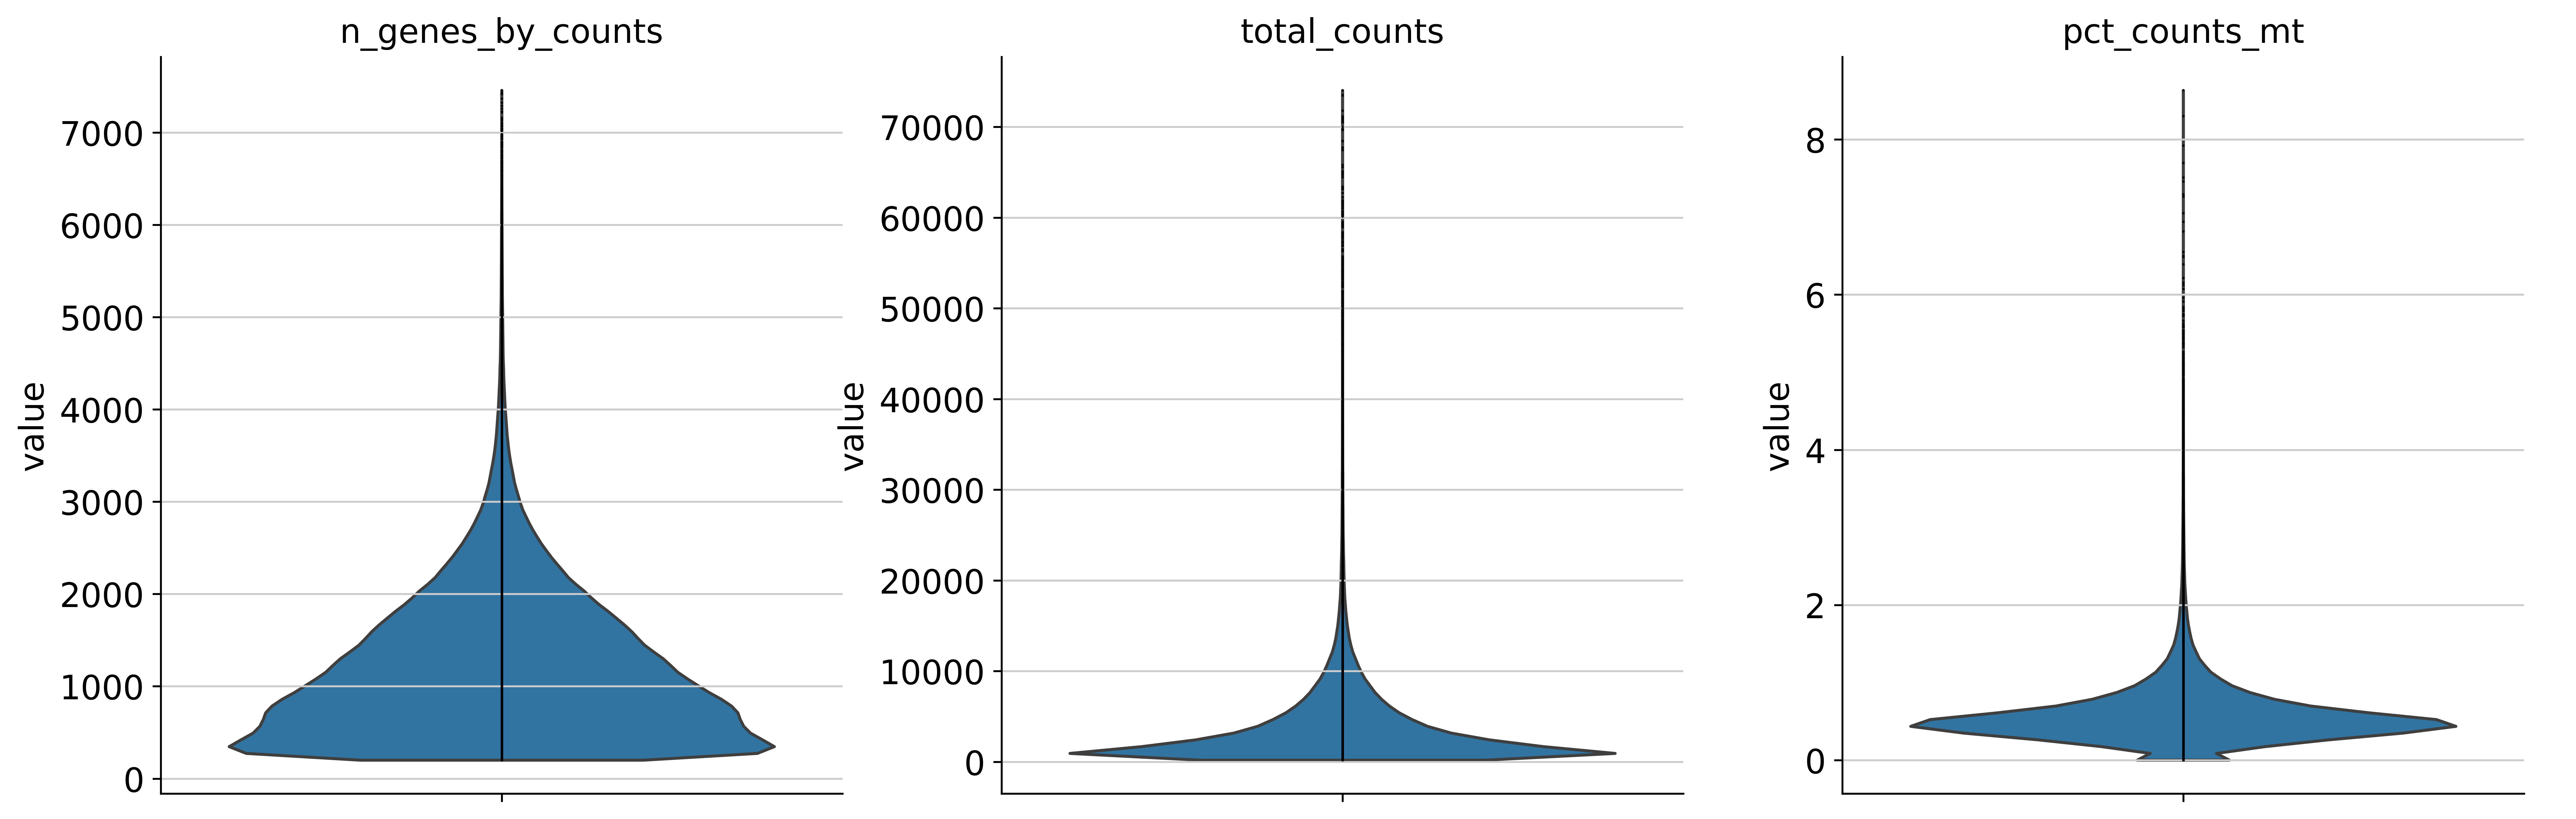

In [236]:
sc.settings.set_figure_params(dpi = 300, facecolor='white')
sc.pl.violin(adata2, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0, multi_panel=True) #need to adjust jitter for non-cluttered plots.

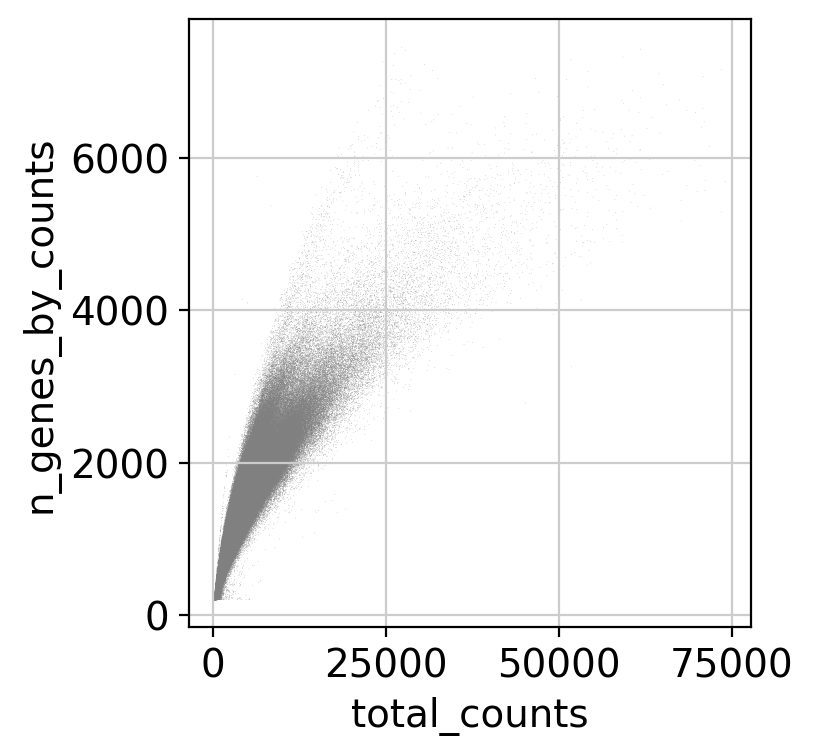

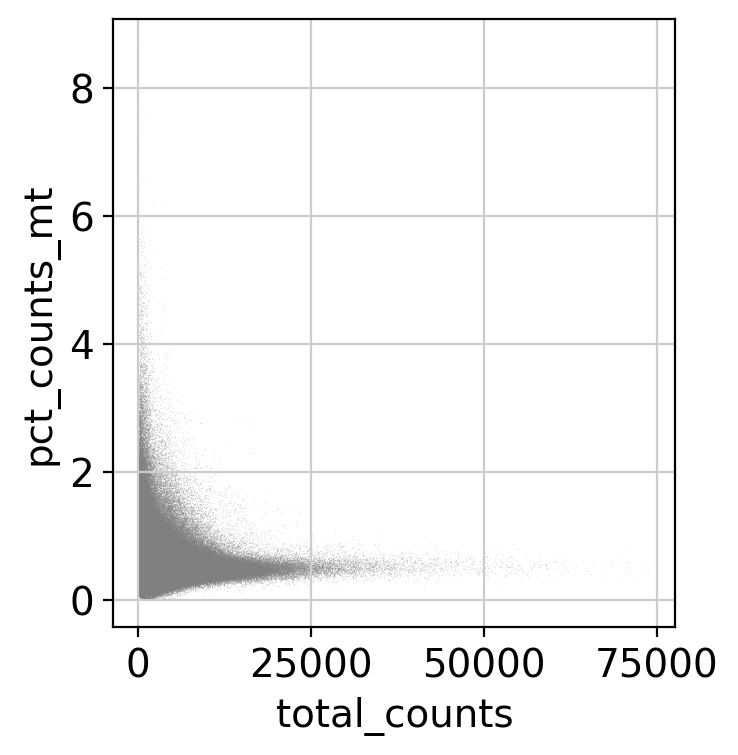

In [237]:
sc.settings.set_figure_params(dpi = 100, facecolor='white')
sc.pl.scatter(adata2, x='total_counts', y='n_genes_by_counts')
sc.pl.scatter(adata2, x="total_counts", y="pct_counts_mt")

In [238]:
# normalization to total genes per cell = 10,000 or 1e4
# accounts for sequencing depth 
sc.pp.normalize_total(adata2, target_sum=1e4)

normalizing counts per cell
    finished (0:00:02)


In [239]:
# log transformation 
# accounts for skewness between high and low expression and makes data suitable for dimensionality reduction
sc.pp.log1p(adata2)

In [240]:
# with all default values (min_mean=0.0125, max_mean=3, min_disp=0.5)
# adds 4 columns to adata.var
# highly expressed genes have higher variance 
sc.pp.highly_variable_genes(adata2)

extracting highly variable genes
    finished (0:00:08)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


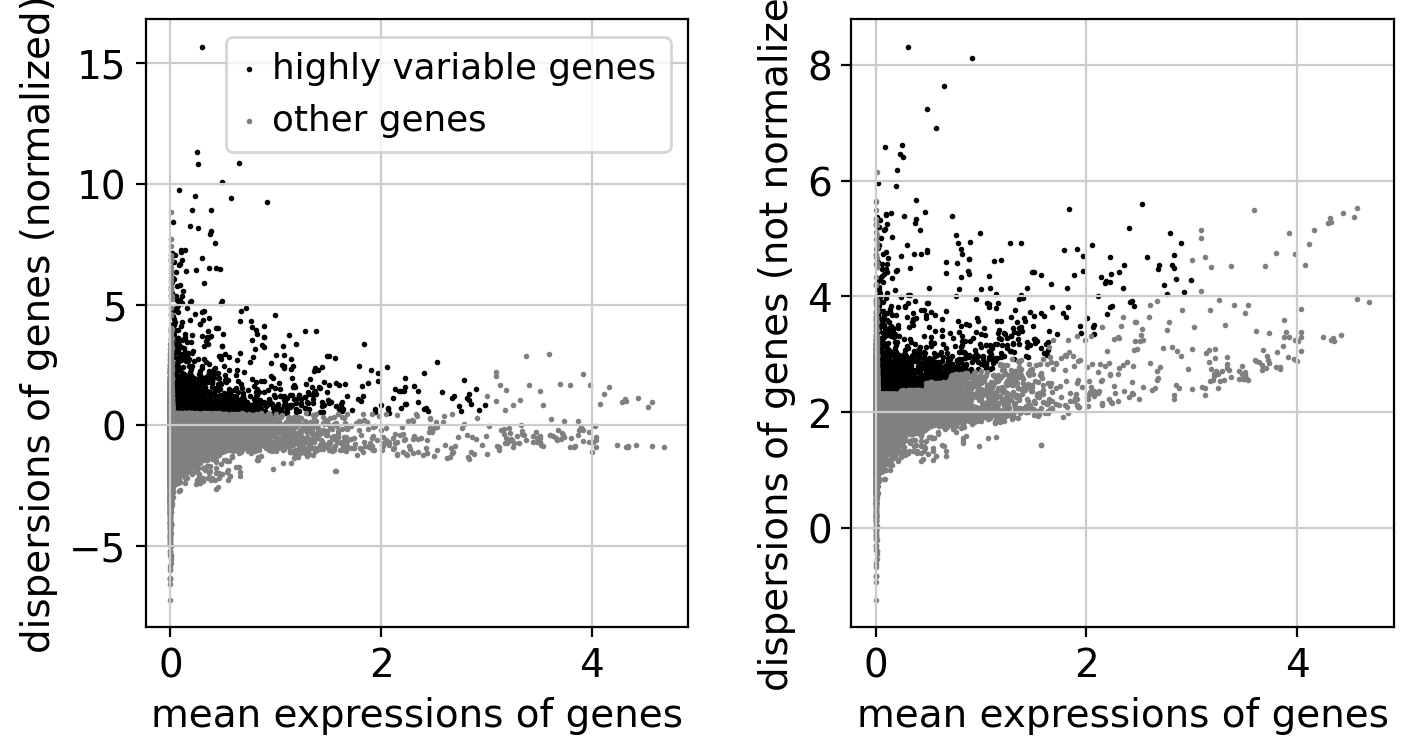

In [241]:
sc.pl.highly_variable_genes(adata2)

In [242]:
# storing the current unscaled data in the raw attribute for further comparison
adata2.raw = adata2
#and can access by calling:
# adata_from_raw = adata.raw.to_adata()

In [243]:
# Not including this step to include all possible information for further exploration.

# Removing/adjusting unwanted variance
# removing/regressing out the effect of total counts per cell and perc of mt genes expressed.
# focus on biological variation rather than technical noise
# sc.pp.regress_out(adata2, ["total_counts", "pct_counts_mt"])

In [244]:
#scaling each gene to unit variance and trimming off values exceeding standard daviation 10.
sc.pp.scale(adata2, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [246]:
sc.tl.pca(adata2, svd_solver='arpack')

#svd_solver is to choose which SVD(singular value decomposition, for dimentionality reduction)
# "arpack" is default, takes time but gives high precision

computing PCA
    with n_comps=50
    finished (0:01:38)


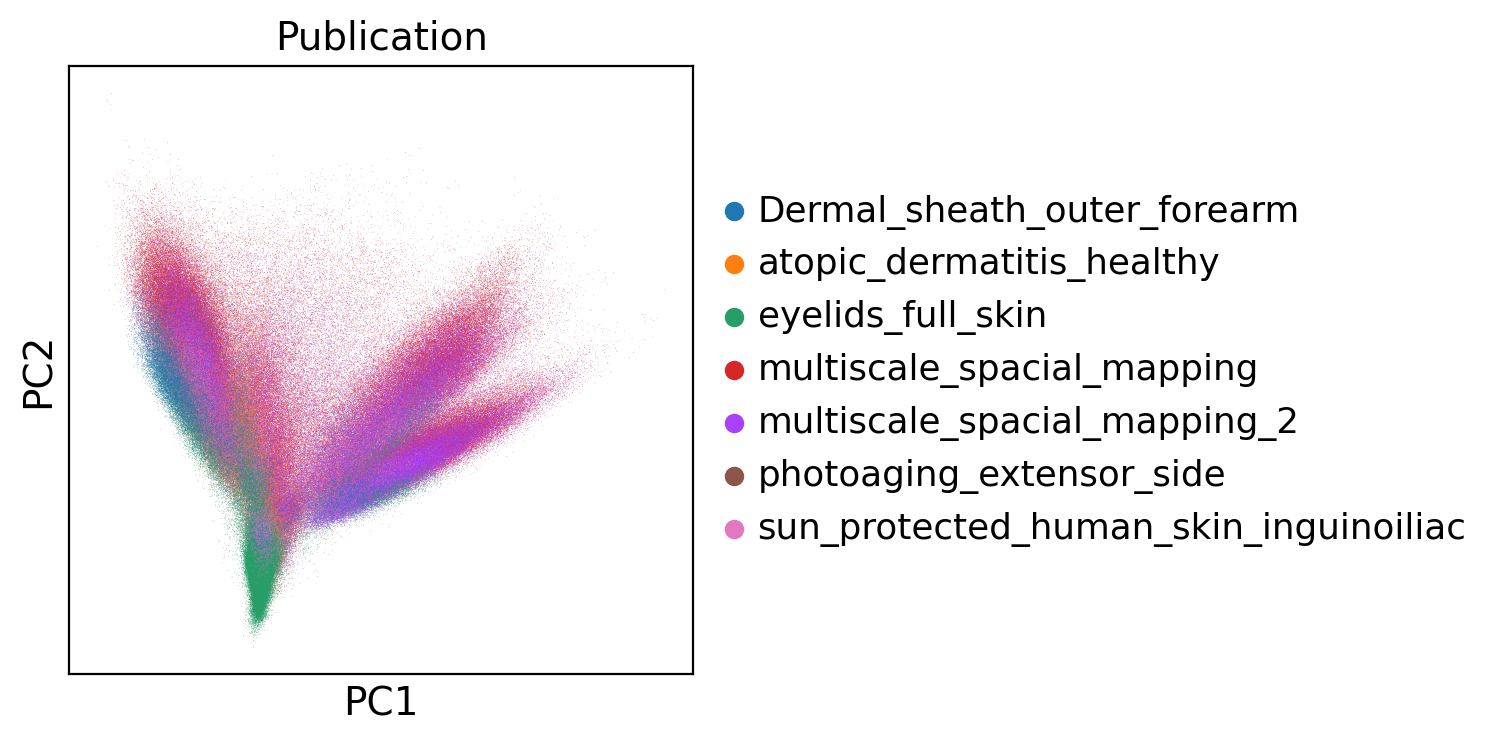

In [247]:
sc.settings.set_figure_params(dpi = 100, facecolor='white')
sc.pl.pca(adata2, color='Publication')

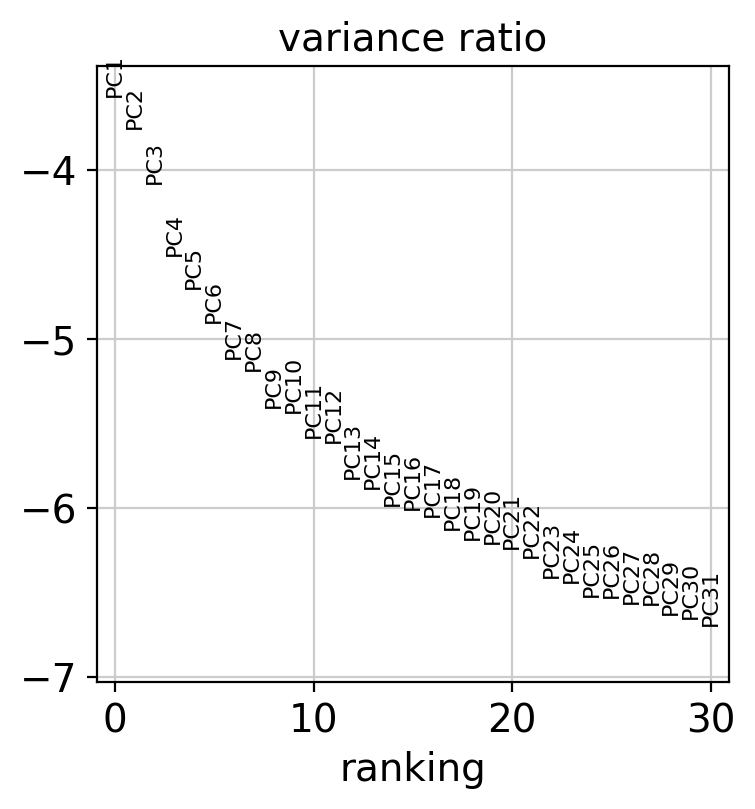

In [248]:
#contribution of each PC in total variance of the data.
sc.pl.pca_variance_ratio(adata2,log=True)

In [251]:
# Neighborhood graph
# using PCA representation of the matrix
sc.pp.neighbors(adata2, n_neighbors=10, n_pcs=40)

# n_neighbors -size of local neighborhood 
# n_pcs -to use this many PCs

# in simple words - it groups similar cells

computing neighbors
    using 'X_pca' with n_pcs = 40


/opt/conda/envs/spatialdata/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:35)


In [252]:
sc.tl.umap(adata2)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:06:48)


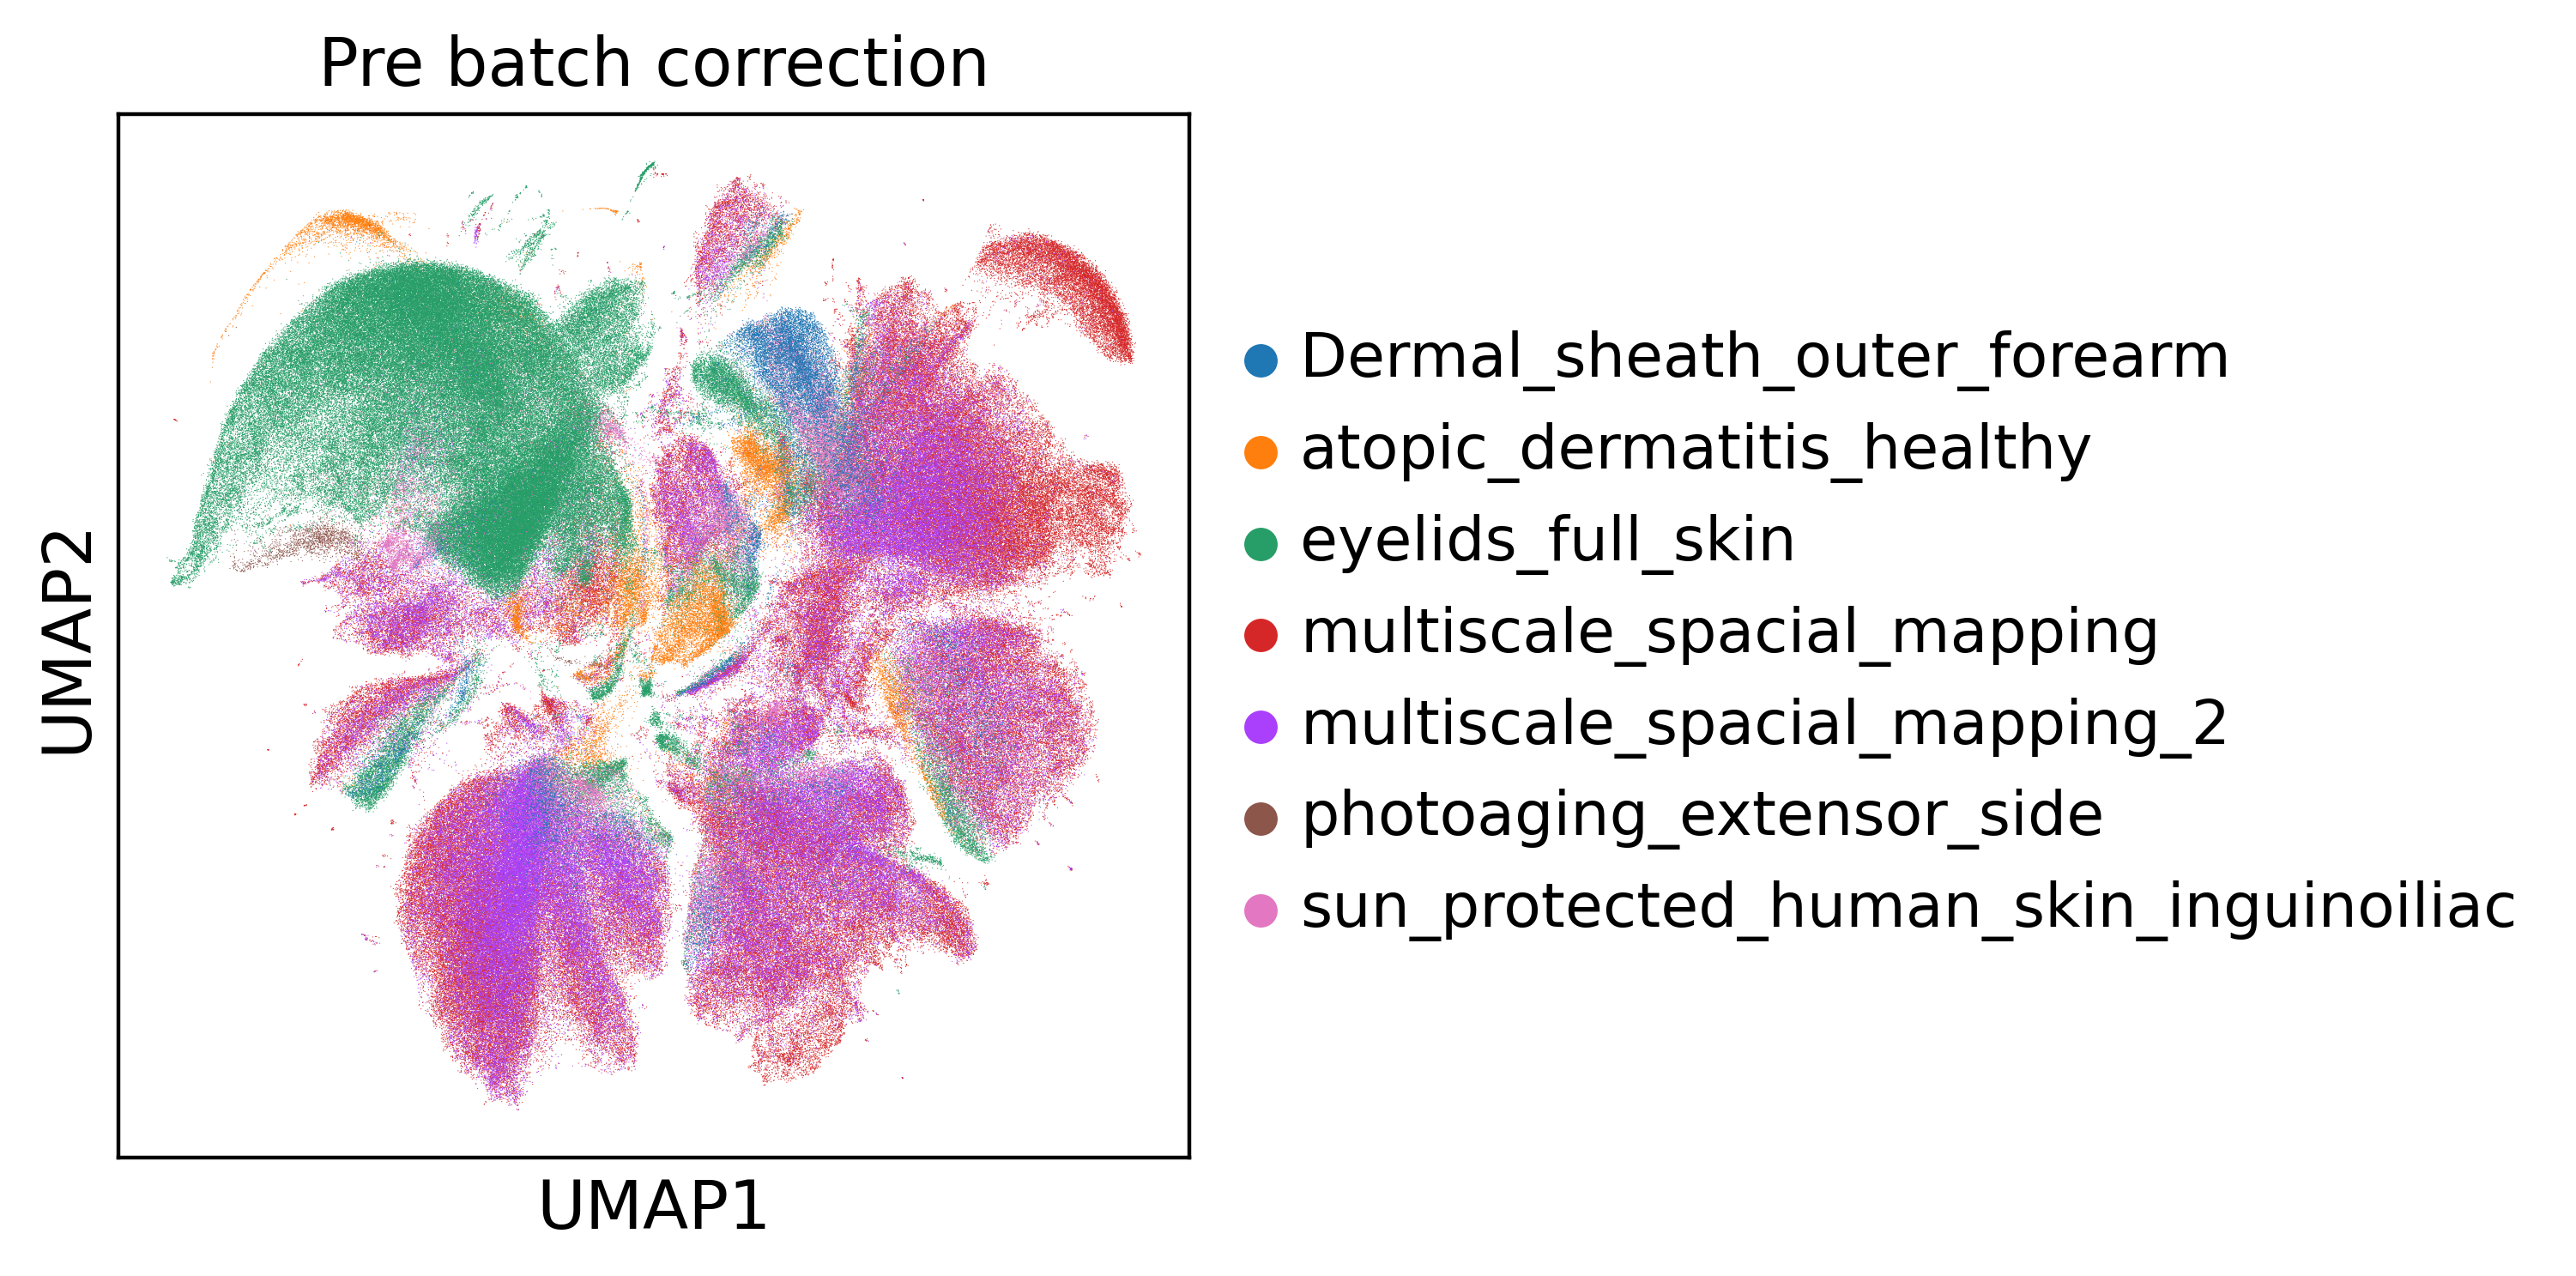

In [253]:
sc.settings.set_figure_params(dpi = 200, facecolor='white')
sc.pl.umap(adata2, color='Publication', title = "Pre batch correction")

In [254]:
adata2.write('/home/jovyan/ifbdata/spatial_cell_id/Kush/Scanpy_analysis/adata_pre_batch_effect.h5ad')